# Simple ARIMA Model for Non-Seasonal Time-Series Forecast

Our goal in this challenge is to apply the basic concepts of time series analysis to one-dimension data

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;

##  1. Load Data
Let's start by loading the Time Series of the challenge. Run the line below to download the dataset as a CSV file, then load the CSV in a DataFrame.

In [1]:
!curl https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/09-Time-Series/www_usage.csv > data/www_usage.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   377  100   377    0     0   2299      0 --:--:-- --:--:-- --:--:--  2371


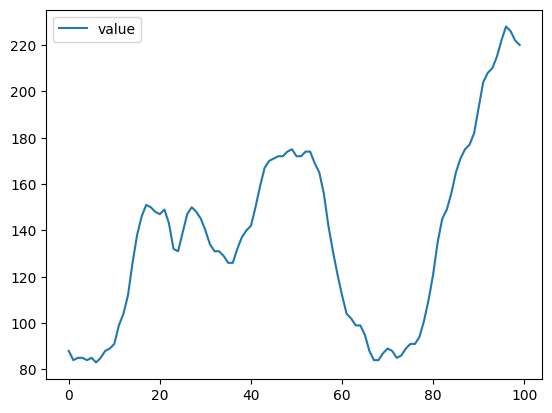

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/www_usage.csv', names=['value'], header=0)
y = df.value

df.plot();


In [55]:
df


,value,diff
0,88,NaN
1,84,-4.0
2,85,1.0
3,85,0.0
4,84,-1.0
...,...,...
95,222,7.0
96,228,6.0
97,226,-2.0
98,222,-4.0


This abstract time series does not seem seasonal, but with some increasing trend and somehow "sticky" (i.e. with some auto-regressivity). So it may be a good candidate for Auto-Regressive Moving Average (ARIMA) models.


## 2. Build ARIMA Model
We will try to forecast the data thanks to ARIMA models (Auto Regressive Integrated Moving Average).

For that, we will need to :
1. find how to stationarize the time series (I in SARIMA)
2. find the auto-regressive (AR) part
3. find the moving average (MA) part
4. Fit
5. Assess performance

### Step 1 - Ensure Stationarity

ARIMA models apply to "stationary" time series only.

👉 Check its stationarity precisely using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html), and especially its p-value

In [3]:
# YOUR CODE HERE
# Find the p value of the ARIMA model
from statsmodels.tsa.stattools import adfuller

p_value = adfuller(df.value)[1]  # p-value
print(f'ADF p-value: {p_value}')


ADF p-value: 0.12441935447109442


The p-value should be less than 0.05 to have a 95% confidence in the stationarity.  
If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

If the time series is not stationary, it needs to be stationarized through **differencing**. 
- It means that we take the difference between each value and the preceding one (*first difference*).
- Repeat the process on the differentiated series if you want the *second difference*, etc...

👉 Find the minimum order of differencing we need to make it stationary (plot the curves to visualize them, and print their adfuller p-value to be sure)

<details>
    <summary>Hint</summary>

`pd.Series.diff`
</details>

ADF p-value for zero_diff: 0.12441935447109442
ADF p-value for first_order_diff: 0.07026846015272728
ADF p-value for second_order_diff: 2.8434287555470966e-17
ADF p-value for third_order_diff: 4.112279771510255e-08


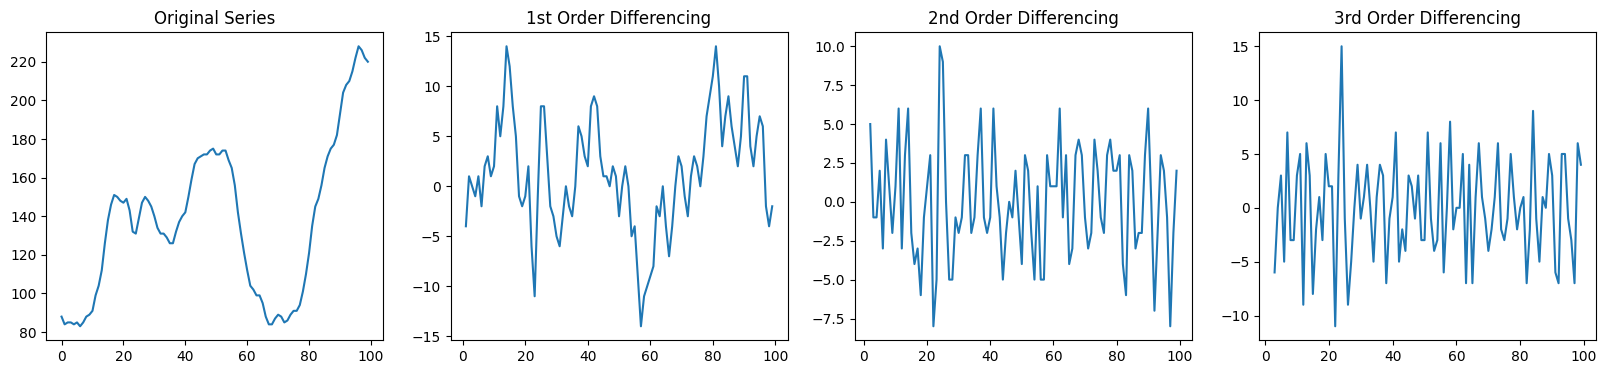

In [9]:
# YOUR CODE HERE
# Keep differencing until the series is stationary and
# plot the results and
# find the minimum number of differencing needed to get a stationary series
zero_diff = df.value
first_order_diff = df.value.diff(1)
second_order_diff = df.value.diff(1).diff(1)
third_order_diff = df.value.diff(1).diff(1).diff(1)


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))
ax1.plot(zero_diff)
ax1.set_title("Original Series")
ax2.plot(first_order_diff)
ax2.set_title("1st Order Differencing")
ax3.plot(second_order_diff)
ax3.set_title("2nd Order Differencing")
ax4.plot(third_order_diff)
ax4.set_title("3rd Order Differencing")

# print the p-values of ADF tests for each of the differenced series
print(f"ADF p-value for zero_diff: {adfuller(zero_diff.dropna())[1]}")
print(f"ADF p-value for first_order_diff: {adfuller(first_order_diff.dropna())[1]}")
print(f"ADF p-value for second_order_diff: {adfuller(second_order_diff.dropna())[1]}")
print(f"ADF p-value for third_order_diff: {adfuller(third_order_diff.dropna())[1]}")


We have a close call here between one and two diff orders. Differentiating time series too much may also reduce the performance of your ARIMA models. Let's have a closer look:

👉 Plot autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) for diff order 1 and 2.

(💡Pro tip: Avoid duplicating statsmodels plots by calling `plt.show()` or by adding `;` to the end of each instantiation of a statsmodels plot)

/Users/tanushrinayak/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0.5, 1.0, '2nd Order Differencing')

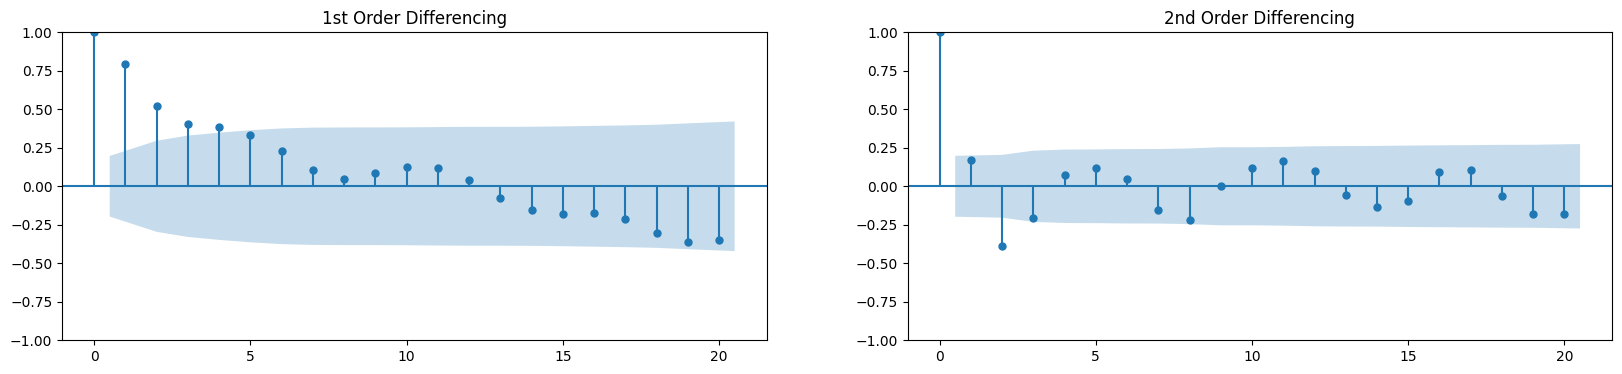

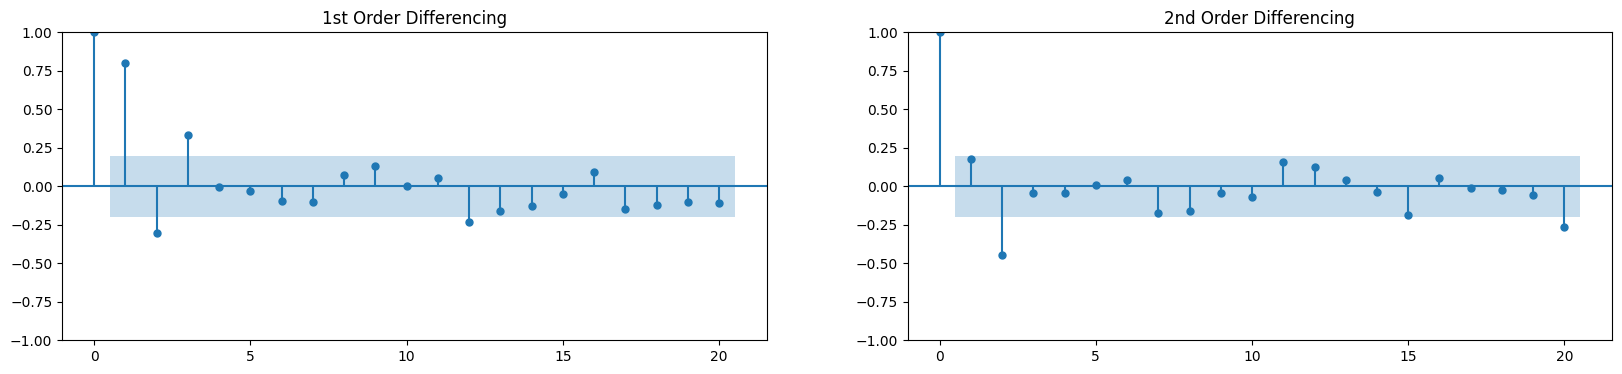

In [19]:
# YOUR CODE HERE
# Plot autocorrelation plot for 1st order differenced series and
# for the 2nd order differenced series

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
plot_acf(first_order_diff.dropna(), ax=ax1);
ax1.set_title("1st Order Differencing")
plot_acf(second_order_diff.dropna(), ax=ax2);
ax2.set_title("2nd Order Differencing")

# Plot partial autocorrelation plot for 1st order differenced series and
# for the 2nd order differenced series

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
plot_pacf(first_order_diff.dropna(), ax=ax1);
ax1.set_title("1st Order Differencing")
plot_pacf(second_order_diff.dropna(), ax=ax2);
ax2.set_title("2nd Order Differencing")


In our "second order diff" autocorrelation plot, the lag coefficient n°1 is close to 0, while the second one escapes far into negative territory. This might indicate we have over-differentiated the series. (Remember: we never care about the lag n°0 which is always equal to 1)

👉 Let's (tentatively) keep only one diff order and name this series `y_diff` (we can always try more diff later)

In [20]:
y_diff = y.diff().dropna()


We just found the term "I" in ARIMA: `d = 1` for 1-diff before stationary ("I" refers to "integration", "d" for differentiation...)


### Step 2 - Select AR order (p) and MA order (q)

#### MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d)}}$ cuts off

MA order (`q`) can be found by looking at the autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to`y_diff`. 

👉 determine `q`

Text(0.5, 1.0, 'Partial Autocorrelation')

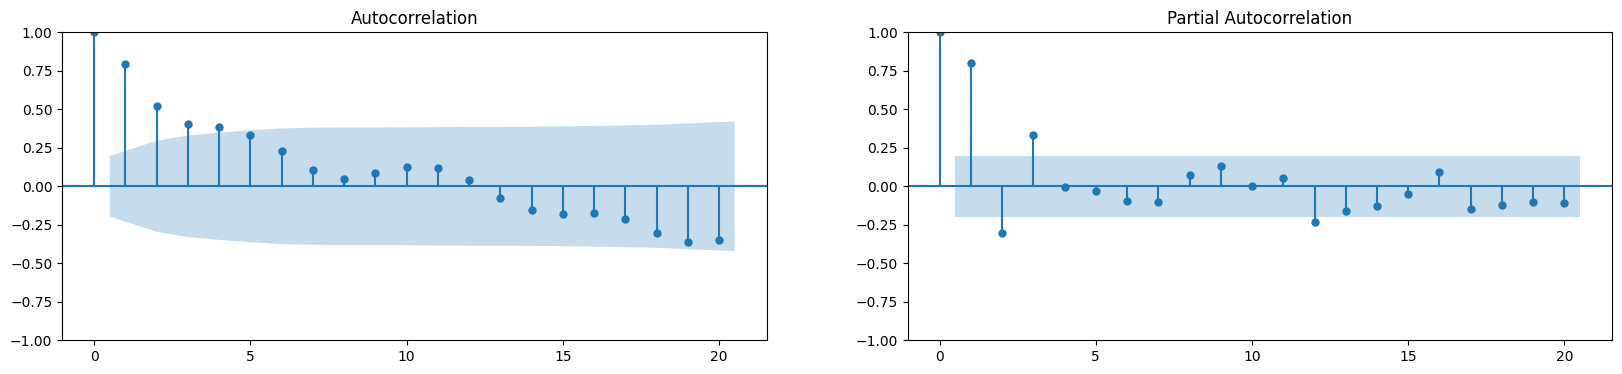

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Determine the (q) value of the ARIMA model

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
plot_acf(y_diff, ax=ax1);
ax1.set_title("Autocorrelation")
plot_pacf(y_diff, ax=ax2);
ax2.set_title("Partial Autocorrelation")


In [22]:
# YOUR CODE HERE
q = 2


The maximum value we should consider for fitting our model seems to be q = 4. However, if we were to use Auto-ARIMA (more on this later) we would find that using q=2 yields ideal results so to begin with, let's try setting q=2. 

When in doubt, go with the simpler model that sufficiently explains the Y.

#### AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d)}}$  cuts off

AR order (`p`) can be found by investigating the **p**artial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to `y_diff`.

(Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series)

👉 Determine `p`

In [26]:
# YOUR CODE HERE
p = 1


We could choose `p = 3` as the first 3 lag terms seem above the significance level, but we could also go with a simpler model `p = 1`. 



### Step 3 - Build the model

Now that you have chosen the values for `p`, ` d`, and `q` for the ARIMA, 

👉 build the `arima_model` from `statsmodels`.
- fit the model
- print the model (`.summary`)

In [27]:
# YOUR CODE HERE
# Build the ARIMA Model - Fit the model,
# print the summary

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(y, order=(p, 1, q))
model = model.fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -254.126
Date:                Thu, 09 Nov 2023   AIC                            516.253
Time:                        11:53:23   BIC                            526.633
Sample:                             0   HQIC                           520.453
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6976      0.130      5.365      0.000       0.443       0.952
ma.L1          0.4551      0.169      2.699      0.007       0.125       0.786
ma.L2         -0.0664      0.157     -0.424      0.671      -0.373       0.241
sigma2         9.7898      1.421      6.889      0.000       7.005      12.575
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.09
Prob(Q):                              0.98   Prob(JB):                         0.95
Heteroskedasticity (H):               0.63   Skew:                            -0.07
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

☝️ If your p-values are too high, try to remove these terms by reducing the corresponding AR or SA coefficients.

You can evaluate the overall performance of your fit by minimizing the [`AIC - Akaike Information Criterion`](https://towardsdatascience.com/the-akaike-information-criterion-c20c8fd832f2) value

It seems that the (1,1,1) ARIMA models have less chance of overfitting (p-values remain low) and maintain a quasi-similar AIC score than other models

## 3. Evaluate model performance

👉 Visualize your model predictions with the `plot_predict()` method

- Look closely at the method default params, especially `dynamic` ones. 
- Do you think your model would have such a good performance in reality?

In [32]:
# Minimize the AIC value by trying different combinations of p and q values
# and find the optimal ARIMA model

import itertools

p = q = range(0, 3)
d = range(1, 2)
pdq = list(itertools.product(p, d, q))

for param in pdq:
    try:
        model = ARIMA(y, order=param)
        model = model.fit()
        print(f'ARIMA{param} - AIC: {model.aic}')
    except:
        continue


ARIMA(0, 1, 0) - AIC: 630.9949951263743
ARIMA(0, 1, 1) - AIC: 549.8058473653715
ARIMA(0, 1, 2) - AIC: 519.8759323531082
ARIMA(1, 1, 0) - AIC: 529.2382577143904
ARIMA(1, 1, 1) - AIC: 514.3002541089143
ARIMA(1, 1, 2) - AIC: 516.2526483555445
ARIMA(2, 1, 0) - AIC: 522.1788743029203
ARIMA(2, 1, 1) - AIC: 516.2922204119434
ARIMA(2, 1, 2) - AIC: 517.1639694195959


/Users/tanushrinayak/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/tanushrinayak/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


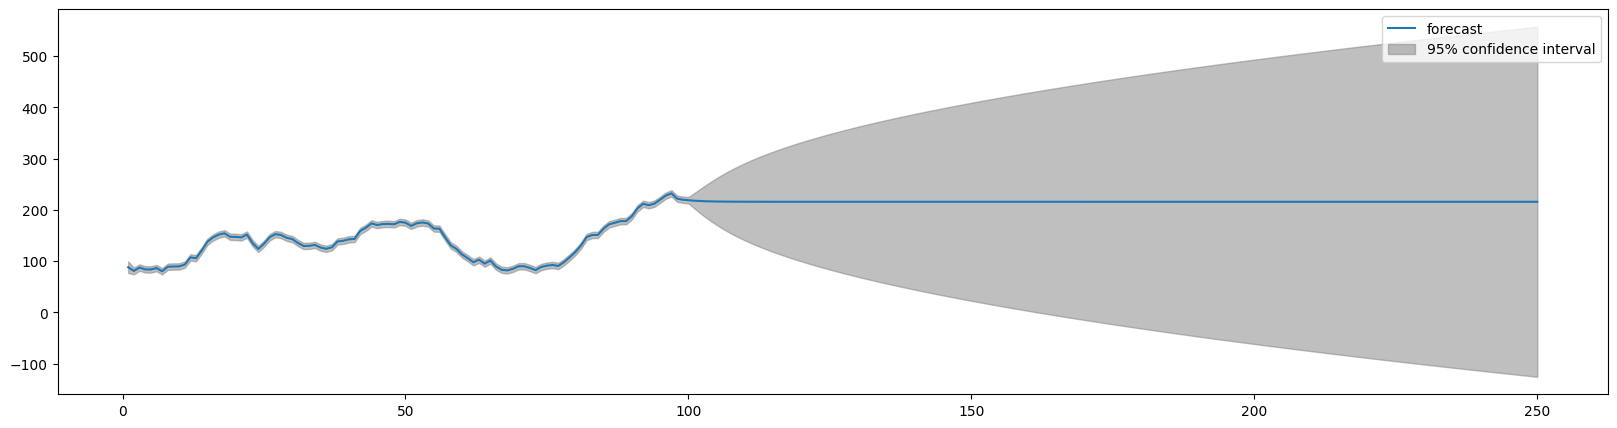

In [30]:
# YOUR CODE HERE
from statsmodels.graphics.tsaplots import plot_predict

# Visualize with plot_predict the results

fig, ax = plt.subplots(figsize=(20, 5))
plot_predict(model, start=1, end=250, ax=ax);


☝️ `dynamic=False` makes use of all available values `y` to predict `y_pred`, making your ARIMA prediction use up to $y_{t-1}$ to predict $y_t$. In reality, you don't have access to all `y`, especially if you want to predict several intervals in the future.

👉 Try to use `dynamic=True` to plot a prediction of the _last 15 values_ in a situation where the model only has _access to data up to 85_. That is to say, the model:
- predicts 86 based on true [1...85]
- then predicts 87 based on [1...85] _plus_ its previously predicted value for 86
- etc...iteratively until 100

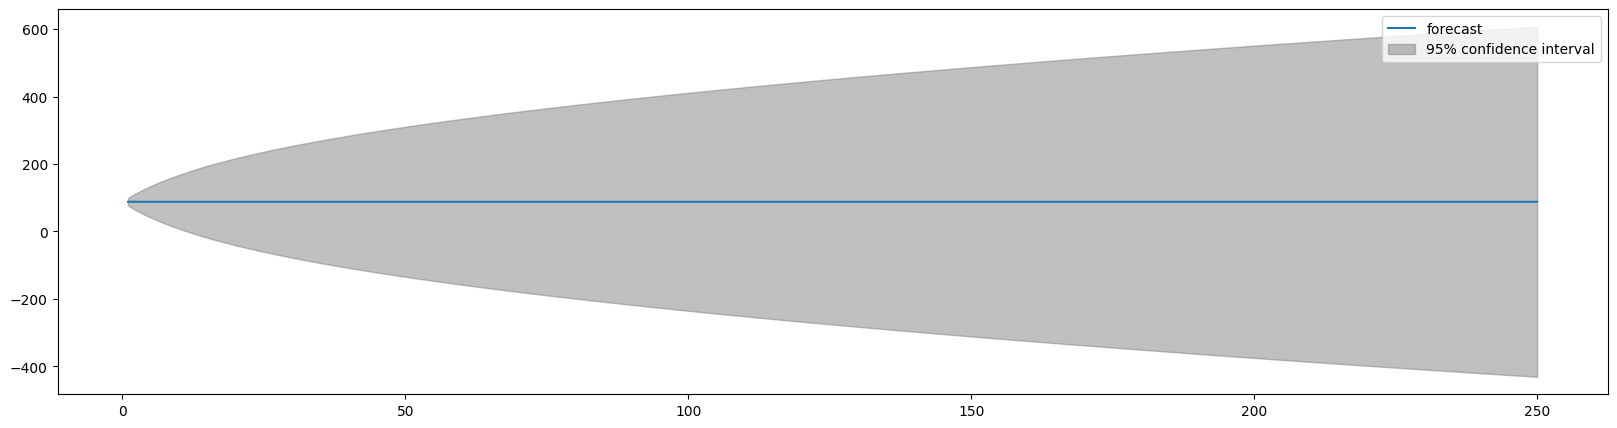

In [34]:
# YOUR CODE HERE
# Use dynamic=True to plot a prediction of last 15 values
# and compare it to the actual values

fig, ax = plt.subplots(figsize=(20, 5))
plot_predict(model, start=1, end=250, ax=ax, dynamic=True);


☝️ That's still not a _true_ forecast! Why?

<details>
    <summary>Answer</summary>

Our model has "seen" the whole `y_true` series during the fitting phase!
</details>

### 3.1 Out-of-Sample Forecasts (real "future")

👉 Create a train-test-split keep the last 15 data points only for the test set, and train your ARIMA on the train set only.

In [35]:
# YOUR CODE HERE
# Create a train-test split to keep the last 15 values for testing and
# fit the model on the train set

train = y[:-15]
test = y[-15:]

model = ARIMA(train, order=(1, 1, 1))
model = model.fit()


👉 We are "now" in step 85 and have never seen the future:
- Use the `get_forecast()` method on your fitted `arima` model to "forecast" the 15 next data points (i.e beyond the end of your train dataset) 

The method returns a `PredictionResultsWrapper` object from `statsmodels`.

**💻 Store this result in a variable named `forecast_results`.**  

It is hard to navigate at first, but here are some tips:
- You can find your forecasts in `forecast_results.predicted_mean`
- Your confidence intervals are given by `forecast_results.conf_int()`

In [38]:
# YOUR CODE HERE

# Forecast values
forecast = model.forecast(len(test), alpha=0.05)  # 95% confidence

# Forecast values and confidence intervals
forecast_results = model.get_forecast(len(test), alpha=0.05)

forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values

print(f'Forecast predicted_mean values: {forecast}')
print(f'Confidence interval: {confidence_int}')


Forecast predicted_mean values: 85    163.161121
86    167.885191
87    171.001581
88    173.057410
89    174.413606
90    175.308266
91    175.898457
92    176.287797
93    176.544638
94    176.714071
95    176.825844
96    176.899578
97    176.948219
98    176.980307
99    177.001475
Name: predicted_mean, dtype: float64
Confidence interval: [[156.92924502 169.39299652]
 [153.13444968 182.63593267]
 [147.66895864 194.3342026 ]
 [141.54236291 204.57245728]
 [135.26000861 213.56720353]
 [129.07568844 221.54084286]
 [123.11075598 228.68615894]
 [117.41545468 235.16013938]
 [112.00205397 241.08722156]
 [106.86317615 246.56496637]
 [101.98200617 251.66968117]
 [ 97.33794244 256.46121365]
 [ 92.90965495 260.98678379]
 [ 88.67666443 265.28395003]
 [ 84.6200828  269.38286728]]


👉 Plot forecasted values as well as the higher and lower range of 95% uncertainty interval

👉 Try to also plot your previous 85 `y` real data points to better grasp model performance relative to the past

Index of test: RangeIndex(start=85, stop=100, step=1)
Lower series: 85    156.929245
86    153.134450
87    147.668959
88    141.542363
89    135.260009
90    129.075688
91    123.110756
92    117.415455
93    112.002054
94    106.863176
95    101.982006
96     97.337942
97     92.909655
98     88.676664
99     84.620083
dtype: float64
Upper series: 85    169.392997
86    182.635933
87    194.334203
88    204.572457
89    213.567204
90    221.540843
91    228.686159
92    235.160139
93    241.087222
94    246.564966
95    251.669681
96    256.461214
97    260.986784
98    265.283950
99    269.382867
dtype: float64


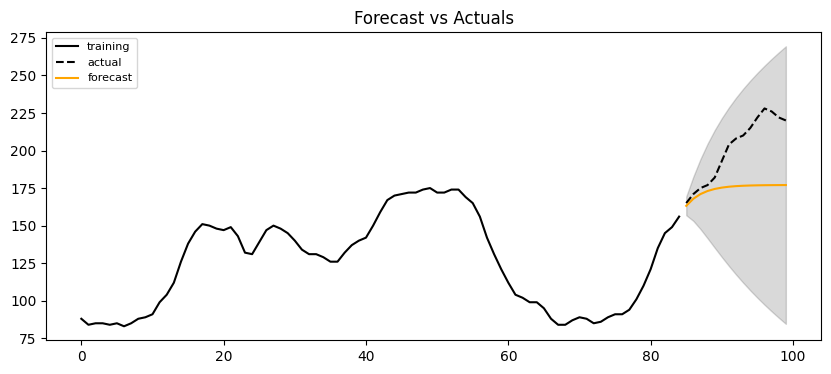

In [44]:
# YOUR CODE HERE

import numpy as np


def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    print(f'Index of test: {test.index}')
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None
    print(f'Lower series: {lower_series}')
    print(f'Upper series: {upper_series}')


    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);


plot_forecast(forecast, train, test, confidence_int[:,0], confidence_int[:,1])


### 3.2 Can you trust your 95% confidence interval? (conditions for inference)

👉 Plot the residuals `model.resid` to ensure there are no patterns
- Normally distributed
- Mean zero
- Uniform variance
- No autoregressive patterns (you can plot_acf the residuals anyway if you want)

Note: residuals are constructed by 'seeing' all data as in `plot_predict(dynamic=False)`

Also, try to plot a histogram or KDE fit of the residuals to see if they are approximately normally distributed.

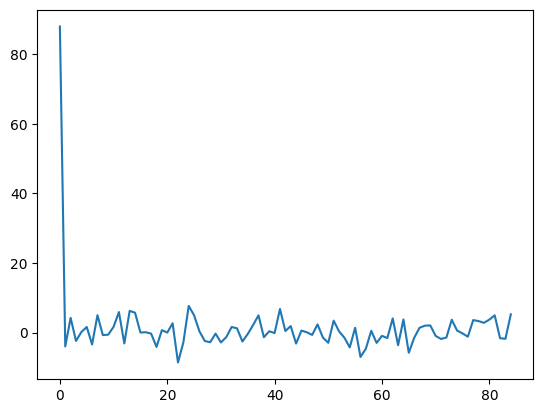

In [47]:
# YOUR CODE HERE
# Plot the residuals to make sure there are no patterns (that is, look for constant mean and variance)

residuals = model.resid
residuals.plot();


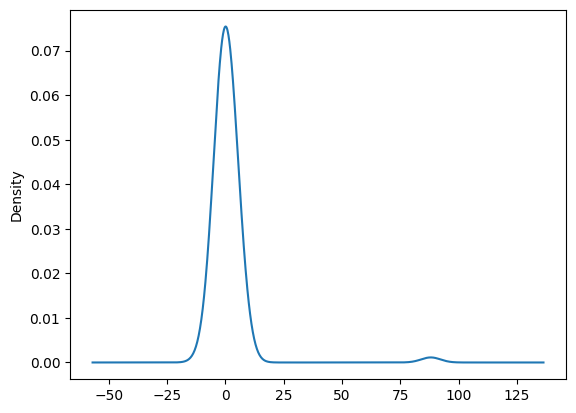

In [48]:
# Plot a KDE fit of the residuals to make sure they are normally distributed
residuals.plot(kind='kde');


## 3.3 Cross-validated performance metrics

👉 Below are the given the most common performance metrics for time series

In [49]:
import numpy as np
from statsmodels.tsa.stattools import acf

def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:

    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error

    forecast = ({
        'mape':mape,
        'me':me,
        'mae': mae,
        'mpe': mpe,
        'rmse':rmse,
        'acf1':acf1,
        'corr':corr,
        'minmax':minmax
    })

    return forecast


👉 Play with your ARIMA hyper-parameters and see the impact on your forecast performance

In [50]:
# YOUR CODE HERE
# Check the ARIMA hyper-parameters and their impact on the forecast accuracy

forecast_accuracy(forecast, test)


{'mape': 0.12522186628001233,
 'me': -26.87149591727022,
 'mae': 26.87149591727022,
 'mpe': -0.12522186628001233,
 'rmse': 32.38238247968934,
 'acf1': 0.8714402841670187,
 'corr': 0.8528510919152512,
 'minmax': 0.12522186628001242}

## 4 Grid Search

Try to run a Grid Search for (p,d,q) using `pmdarima`. Use at least
- `test='adf'`
- `trace=True`
- `error_action='ignore'`
- `suppress_warnings=True`

In [52]:
import pmdarima as pm

y_train = train
model = pm.auto_arima(
    y_train,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=None,           # let model determine 'd'
    test='adf',       # using adf test to find optimal 'd'
    trace=True, error_action='ignore',  suppress_warnings=True
)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=449.662, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=449.569, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=445.819, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=445.820, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=441.300, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=438.613, Time=0.02 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=440.036, Time=0.05 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=440.231, Time=0.04 sec

Best model:  ARIMA(0,2,3)(0,0,0)[0]          
Total fit time: 0.299 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   85
Model:               SARIMAX(0, 2, 3)   Log Likelihood                -215.307
Date:                Thu, 09 Nov 2023   AIC                   

## (Optional) Cross-validate the Performance of your Model

In practice, results and Grid Search should always be cross-validated: 

Feel free to use [`sklearn.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to create contiguous K-folds to truly evaluate the performance of your model and find the best hyperparams after cross-validation.

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_013.png'>

**ARIMA - Cross-Validation using TimeSeriesSplit + Grid Search**

In [53]:
# YOUR CODE HERE
# Use TimeSeriesSplit to create contiguous K-folds for cross-validation and
# find the optimal hyper-parameters after cross-validation

from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(y):
    print("TRAIN:", train_index, "TEST:", test_index)
    y_train, y_test = y[train_index], y[test_index]
    print(y_train, y_test)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35]
0      88
1      84
2      85
3      85
4      84
5      85
6      83
7      85
8      88
9      89
10     91
11     99
12    104
13    112
14    126
15    138
16    146
17    151
18    150
19    148
Name: value, dtype: int64 20    147
21    149
22    143
23    132
24    131
25    139
26    147
27    150
28    148
29    145
30    140
31    134
32    131
33    131
34    129
35    126
Name: value, dtype: int64
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] TEST: [36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51]
0      88
1      84
2      85
3      85
4      84
5      85
6      83
7      85
8      88
9      89
10     91
11     99
12    104
13    112
14    126
15    138
16    146
17    151
18    150
19    148
20    147
21    149
22    143
23    132
24    131
25    139
26    147
27    150
28    148

In [59]:
# Create a dataframe with columns (p, d, q) and AIC value of the model

import itertools

p = q = range(0, 3)
d = range(1, 2)
pdq = list(itertools.product(p, d, q))

df = pd.DataFrame(columns=['(p, d, q)', 'AIC'])

# for each combination of (p, d, q) values
for param in pdq:
    try:
        model = ARIMA(y, order=param)
        model = model.fit()
        df = df.append({'(p, d, q)': param, 'AIC': model.aic}, ignore_index=True)
    except:
        continue

df.sort_values('AIC').groupby('(p, d, q)').mean()['AIC'].sort_values()


/var/folders/yl/4cykn24n6fbdrmpdpzlfbpjc0000gn/T/ipykernel_32217/3289518637.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'(p, d, q)': param, 'AIC': model.aic}, ignore_index=True)
/Users/tanushrinayak/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/var/folders/yl/4cykn24n6fbdrmpdpzlfbpjc0000gn/T/ipykernel_32217/3289518637.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'(p, d, q)': param, 'AIC': model.aic}, ignore_index=True)
/var/folders/yl/4cykn24n6fbdrmpdpzlfbpjc0000gn/T/ipykernel_32217/3289518637.py:16: FutureWarning: The frame.append method is deprecated and

(p, d, q)
(1, 1, 1)    514.300254
(1, 1, 2)    516.252648
(2, 1, 1)    516.292220
(2, 1, 2)    517.163969
(0, 1, 2)    519.875932
(2, 1, 0)    522.178874
(1, 1, 0)    529.238258
(0, 1, 1)    549.805847
(0, 1, 0)    630.994995
Name: AIC, dtype: float64

☝️ Our initial choice of model (1, 1, 2) is not so bad!
Notice that the dataset (100 data points) is in reality way too small to cross-validate anything!